In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [2]:
#To check the availability of the GPU
!nvidia-smi

Fri Mar 18 08:46:42 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 466.77       Driver Version: 466.77       CUDA Version: 11.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   47C    P0    12W /  N/A |    106MiB /  4096MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
#Hyperparameters to tune the model
batch_size=8
num_epochs=25
lr=0.001

In [4]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'D:/Anaconda Environment/Object Detection Pytorch/Classification/data4'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

Using Device cuda:0


In [ ]:
#Allocating the device to the GPU or CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#Checking for the device in use
print("Using Device",device)

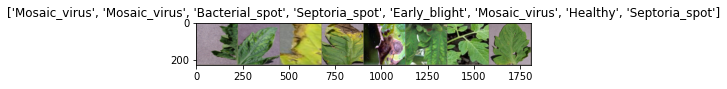

In [5]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                save_checkpoint(model, epoch, optimizer, best_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    print('Best val loss: {:4f}'.format(best_loss))
    print('Learning rate: {:4f}'.format(lr))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [7]:
def visualize_model(model, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return model
        model.train(mode=was_training)

In [8]:
#Saving the model
def save_checkpoint(model, epoch, optimizer, best_acc):
    state = {
        'epoch': epoch,
        'model' :model.state_dict(),
        'Best Validation Accuracy' : best_acc,
        'optimizer' : optimizer.state_dict(),
    }
    torch.save(state,'Exported Model/efficientnet_b0_final.pth')

In [9]:
model_fn = models.efficientnet_b0(pretrained=True)

#num_ftrs = model_fn.fc.in_features#Used for Resnet50

num_ftrs = model_fn.classifier[1].in_features #Used for EfficientNetB0 and MobileNetV2

# Here the size of each output sample is set to 7.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).


#model_fn.fc = nn.Linear(num_ftrs, 7) #Used for Resnet50

model_fn.classifier[1] = nn.Linear(num_ftrs, 7) #Used for EfficientNetB0 and MobileNetV2
#Allocating the model to GPU
model_fn = model_fn.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_fn.pVarameters(), lr, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [10]:
model_fn = train_model(model_fn, criterion, optimizer_ft, exp_lr_scheduler, num_epochs)

Epoch 0/24
----------
train Loss: 1.2158 Acc: 0.6025
val Loss: 0.7559 Acc: 0.7300

Epoch 1/24
----------
train Loss: 0.6484 Acc: 0.7850
val Loss: 0.5824 Acc: 0.7771

Epoch 2/24
----------
train Loss: 0.5487 Acc: 0.8057
val Loss: 0.5470 Acc: 0.7857

Epoch 3/24
----------
train Loss: 0.5066 Acc: 0.8211
val Loss: 0.4463 Acc: 0.8400

Epoch 4/24
----------
train Loss: 0.4498 Acc: 0.8486
val Loss: 0.4641 Acc: 0.8200

Epoch 5/24
----------
train Loss: 0.4220 Acc: 0.8586
val Loss: 0.4875 Acc: 0.8100

Epoch 6/24
----------
train Loss: 0.3767 Acc: 0.8775
val Loss: 0.4931 Acc: 0.8243

Epoch 7/24
----------
train Loss: 0.3419 Acc: 0.8868
val Loss: 0.4500 Acc: 0.8300

Epoch 8/24
----------
train Loss: 0.3566 Acc: 0.8807
val Loss: 0.4139 Acc: 0.8529

Epoch 9/24
----------
train Loss: 0.3352 Acc: 0.8821
val Loss: 0.4458 Acc: 0.8429

Epoch 10/24
----------
train Loss: 0.3087 Acc: 0.8932
val Loss: 0.4317 Acc: 0.8443

Epoch 11/24
----------
train Loss: 0.3395 Acc: 0.8836
val Loss: 0.4264 Acc: 0.8371

Ep

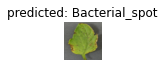

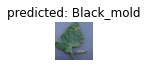

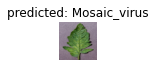

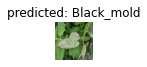

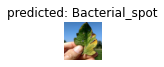

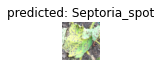

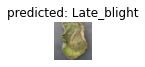

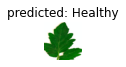

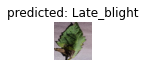

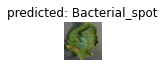

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [11]:
# Visualize the trained model
visualize_model(model_fn)

In [12]:
checkpoint = torch.load('Exported Model/efficientnet_b0_final.pth')

In [17]:
model_fn = models.efficientnet_b0()
num_ftrs = model_fn.classifier[1].in_features
model_fn.classifier[1] = nn.Linear(num_ftrs, 7)
model_fn.load_state_dict(checkpoint['model'])

torch.save(model_fn, 'Exported Model/efficientnet_b0_final.pth')